# Writing Feedback Learning Analytics

This notebook explores how writing changes **before and after** feedback.
It uses a small dataset of student paragraphs, feedback types, and scores
to show simple learning analytics. It connects to Project 1 by loading persona_feedback_outputs.csv, then creates an “after” version for each persona, computes simple metrics, and charts persona impact.


In [1]:
!pip -q install openai pandas numpy matplotlib textstat



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.7 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textstat
from openai import OpenAI

pd.set_option("display.max_colwidth", 160)


Upload the CSV

In [5]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("persona_feedback_outputs.csv")
df.head()


Saving persona_feedback_outputs.csv to persona_feedback_outputs (1).csv


,essay_id,persona,essay,feedback,rubric
0,1,critic,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
1,1,explainer,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
2,1,supporter,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","You’ve done a great job stating your opinion clearly and acknowledging the opposing view, which makes your paragraph balanced and thoughtful. Your main reas...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
3,1,planner,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is some feedback to help you improve your paragraph:\n\n1. Clarity:\n- Your main idea is that school uniforms should be banned because they limit stude...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
4,1,combined,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","Here is some clear, structured feedback to help you improve your paragraph:\n\n1. **State Your Opinion Clearly at the Start** \n Begin with a strong topi...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."


In [6]:
print(df.columns.tolist())
print("Rows:", len(df))
print("Unique essays:", df["essay_id"].nunique())
print("Personas:", sorted(df["persona"].unique()))


['essay_id', 'persona', 'essay', 'feedback', 'rubric']
Rows: 10
Unique essays: 2
Personas: ['combined', 'critic', 'explainer', 'planner', 'supporter']


API client and safe key check

In [10]:
api_key = os.getenv("" ).strip()
client = OpenAI(api_key=api_key) if api_key else None

print("API key loaded:", bool(api_key))


API key loaded: True


Generate “after” writing from persona feedback

In [11]:
REWRITE_MODEL = "gpt-4.1-mini"

def rewrite_with_feedback(before_text: str, feedback: str) -> str:
    if client is None:
        return ""
    prompt = (
        "Rewrite the student paragraph by applying the feedback.\n\n"
        "Rules:\n"
        "- Keep the meaning\n"
        "- Improve clarity, structure, and argument\n"
        "- Use 3 to 5 sentences\n"
        "- Output only the revised paragraph\n\n"
        "STUDENT PARAGRAPH:\n"
        f"{before_text}\n\n"
        "FEEDBACK:\n"
        f"{feedback}\n"
    )
    resp = client.chat.completions.create(
        model=REWRITE_MODEL,
        messages=[
            {"role": "system", "content": "You rewrite student writing using feedback."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.2,
    )
    return resp.choices[0].message.content.strip()

df["after_essay"] = df.apply(lambda r: rewrite_with_feedback(r["essay"], r["feedback"]), axis=1)
df.head()


,essay_id,persona,essay,feedback,rubric,after_essay
0,1,critic,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed...",School uniforms should be banned because they restrict students’ freedom to express their individuality and do not necessarily lead to better behaviour. Man...
1,1,explainer,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed...",I believe school uniforms should be banned because they limit students’ freedom to express themselves and do not always improve behavior. Students need to w...
2,1,supporter,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","You’ve done a great job stating your opinion clearly and acknowledging the opposing view, which makes your paragraph balanced and thoughtful. Your main reas...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed...","School uniforms should be banned because many students feel uncomfortable and restricted by wearing identical clothing, which limits their freedom to expres..."
3,1,planner,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is some feedback to help you improve your paragraph:\n\n1. Clarity:\n- Your main idea is that school uniforms should be banned because they limit stude...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed...","I believe school uniforms should be banned because they restrict students’ freedom to express their individuality. First, forcing everyone to wear the same ..."
4,1,combined,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","Here is some clear, structured feedback to help you improve your paragraph:\n\n1. **State Your Opinion Clearly at the Start** \n Begin with a strong topi...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed...","I believe school uniforms should be banned because they limit students’ freedom to express themselves and do not always improve behavior. First, allowing st..."


Basic text metrics

In [12]:
def word_count(t: str) -> int:
    return len(re.findall(r"\b\w+\b", t or ""))

def sentence_count(t: str) -> int:
    return len([s for s in re.split(r"[.!?]+", t or "") if s.strip()])

def avg_sentence_length(t: str) -> float:
    sc = sentence_count(t)
    return word_count(t) / sc if sc else 0.0

def flesch_reading_ease_safe(t: str) -> float:
    t = t or ""
    try:
        return float(textstat.flesch_reading_ease(t))
    except Exception:
        return np.nan

df["before_word_count"] = df["essay"].apply(word_count)
df["after_word_count"] = df["after_essay"].apply(word_count)

df["before_sentence_count"] = df["essay"].apply(sentence_count)
df["after_sentence_count"] = df["after_essay"].apply(sentence_count)

df["before_asl"] = df["essay"].apply(avg_sentence_length)
df["after_asl"] = df["after_essay"].apply(avg_sentence_length)

df["before_flesch"] = df["essay"].apply(flesch_reading_ease_safe)
df["after_flesch"] = df["after_essay"].apply(flesch_reading_ease_safe)

df["word_count_diff"] = df["after_word_count"] - df["before_word_count"]
df["sentence_count_diff"] = df["after_sentence_count"] - df["before_sentence_count"]
df["flesch_diff"] = df["after_flesch"] - df["before_flesch"]

df[["essay_id","persona","before_word_count","after_word_count","word_count_diff","before_flesch","after_flesch","flesch_diff"]].head()


,essay_id,persona,before_word_count,after_word_count,word_count_diff,before_flesch,after_flesch,flesch_diff
0,1,critic,43,86,43,49.259012,27.617151,-21.641860
1,1,explainer,43,92,49,49.259012,44.706826,-4.552186
2,1,supporter,43,65,22,49.259012,28.658718,-20.600294
3,1,planner,43,86,43,49.259012,25.356471,-23.902541
4,1,combined,43,86,43,49.259012,22.144442,-27.114570


rubric scoring with an LLM




In [13]:
SCORE_MODEL = "gpt-4.1-mini"

rubric = (
    "Score each dimension from 1 to 5.\n"
    "Return strict JSON with keys: clarity, structure, argument.\n"
    "No extra text.\n"
    "Definitions:\n"
    "1 = weak, unclear, hard to follow\n"
    "3 = acceptable, some issues\n"
    "5 = clear, well structured, strong argument\n"
)

def score_text_llm(t: str) -> dict:
    if client is None:
        return {"clarity": np.nan, "structure": np.nan, "argument": np.nan}
    prompt = f"{rubric}\n\nTEXT:\n{t}"
    resp = client.chat.completions.create(
        model=SCORE_MODEL,
        messages=[
            {"role": "system", "content": "You are a strict rubric scorer."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.0,
    )
    raw = resp.choices[0].message.content.strip()
    try:
        import json
        d = json.loads(raw)
        return {
            "clarity": float(d.get("clarity", np.nan)),
            "structure": float(d.get("structure", np.nan)),
            "argument": float(d.get("argument", np.nan)),
        }
    except Exception:
        return {"clarity": np.nan, "structure": np.nan, "argument": np.nan}

df_scores_before = df["essay"].apply(score_text_llm).apply(pd.Series).add_prefix("before_")
df_scores_after = df["after_essay"].apply(score_text_llm).apply(pd.Series).add_prefix("after_")

df2 = pd.concat([df, df_scores_before, df_scores_after], axis=1)

df2["clarity_diff"] = df2["after_clarity"] - df2["before_clarity"]
df2["structure_diff"] = df2["after_structure"] - df2["before_structure"]
df2["argument_diff"] = df2["after_argument"] - df2["before_argument"]

df2[["essay_id","persona","before_clarity","after_clarity","clarity_diff"]].head()


,essay_id,persona,before_clarity,after_clarity,clarity_diff
0,1,critic,3.0,5.0,2.0
1,1,explainer,3.0,4.0,1.0
2,1,supporter,3.0,5.0,2.0
3,1,planner,3.0,5.0,2.0
4,1,combined,3.0,5.0,2.0


Persona effectiveness summary

In [14]:
summary = (
    df2.groupby("persona")[["clarity_diff","structure_diff","argument_diff","flesch_diff","word_count_diff"]]
    .mean()
    .sort_values("clarity_diff", ascending=False)
    .reset_index()
)

summary


,persona,clarity_diff,structure_diff,argument_diff,flesch_diff,word_count_diff
0,combined,1.5,2.0,1.0,-38.597217,49.0
1,critic,1.5,2.0,1.0,-46.375930,39.5
2,planner,1.5,2.0,1.0,-31.526151,44.0
3,supporter,1.5,2.0,1.0,-44.436728,32.0
4,explainer,1.0,1.5,0.5,-29.297164,44.5


Visuals: Clarity improvement by persona

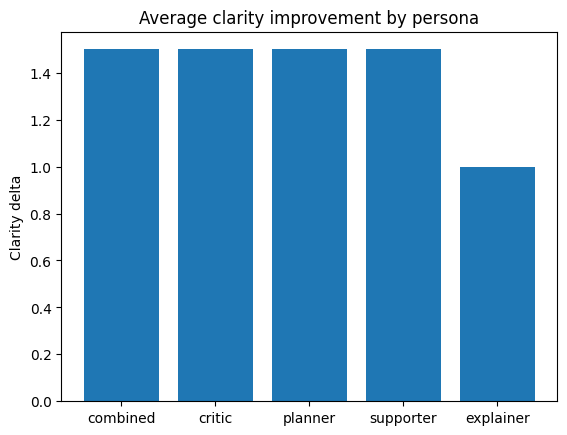

In [15]:
plt.figure()
plt.bar(summary["persona"], summary["clarity_diff"])
plt.title("Average clarity improvement by persona")
plt.ylabel("Clarity delta")
plt.xticks(rotation=0)
plt.show()


Structure improvement by persona

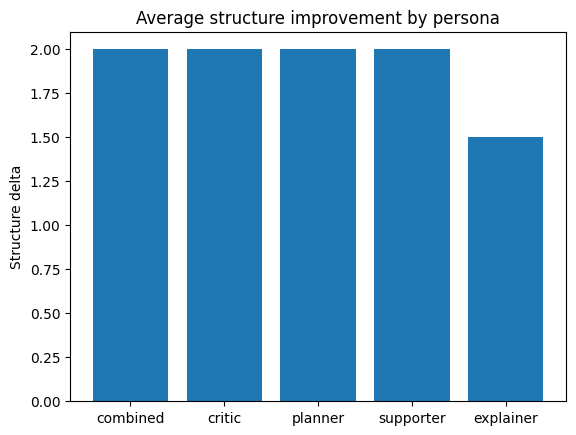

In [16]:
plt.figure()
plt.bar(summary["persona"], summary["structure_diff"])
plt.title("Average structure improvement by persona")
plt.ylabel("Structure delta")
plt.xticks(rotation=0)
plt.show()


Interpretation of Results

The results show clear differences in how each AI persona contributes to writing improvement.

• The critic, planner, and supporter personas produced the strongest improvements in clarity and structure. This suggests that direct critique, explicit organisation guidance, and balanced encouragement are particularly effective for helping learners refine their writing.

• The explainer persona showed lower average improvements across most metrics. While its step-by-step guidance may be helpful for understanding, it appears less effective on its own for driving measurable changes in clarity and structure within short writing samples.

• The combined feedback consistently performs at or near the top across all metrics. This supports the idea that aggregating multiple perspectives leads to more balanced and actionable feedback than relying on a single feedback style.

• Reductions in readability scores (Flesch differences) indicate that some feedback led to more complex sentence structures. This highlights a trade-off between improving argument strength and maintaining simple readability, which is important to consider in educational settings.

• These findings suggest that multi-persona feedback systems may better support diverse learner needs by combining critique, planning, explanation, and encouragement rather than privileging one approach.

Limitations:
The analysis is based on a small number of sample essays and manually defined evaluation measures. Results should therefore be interpreted as exploratory rather than conclusive. Future work would benefit from larger datasets and learner-rated outcome measures.

Save outputs for repo

In [17]:
df2.to_csv("project2_before_after_scored.csv", index=False)
summary.to_csv("project2_persona_summary.csv", index=False)

from google.colab import files
files.download("project2_before_after_scored.csv")
files.download("project2_persona_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>